In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
user_engagement = pd.read_csv('takehome_user_engagement.csv')
users = pd.read_csv('takehome_users.csv', encoding= 'latin1')

In [3]:
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
# Check if there are multiple visits per time stamp
user_engagement.visited.unique()

array([1])

In [5]:
# Clean time stamp to usable format
user_engagement.index = pd.DatetimeIndex(user_engagement.time_stamp)
user_engagement['date'] = user_engagement.index.date
user_engagement = user_engagement.drop('time_stamp', axis=1)
user_engagement_df = user_engagement.groupby(['user_id', 'date']).count().unstack(level=0).fillna(0).droplevel(level=0, axis=1)
user_engagement_df.index = pd.DatetimeIndex(user_engagement_df.index)

In [6]:
# Check if there are any multiple logins in one day - Checks if sum of multiple rows reflects number of days
adopted_user = []
for x in range(len(user_engagement_df.columns)):
    if any(user_engagement_df.iloc[:,x] > 1):
        users_adopted.append(user_engagement_df.columns[x])

print(len(adopted_user))

0


In [7]:
# Find adopted users with a rolling sum, of window 7 for 1 week.
ue_rolling = user_engagement_df.rolling(7, min_periods=0).sum()
adopted_user = []
for x in range(len(ue_rolling.columns)):
    if any(ue_rolling.iloc[:,x] > 2):
        adopted_user.append(ue_rolling.columns[x])

print(len(adopted_user), 'users have 3 or more logins in one seven-day period')

1602 users have 3 or more logins in one seven-day period


In [8]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
users.describe()

,object_id,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
count,12000.00000,8.823000e+03,12000.000000,12000.000000,12000.000000,6417.000000
mean,6000.50000,1.379279e+09,0.249500,0.149333,141.884583,5962.957145
std,3464.24595,1.953116e+07,0.432742,0.356432,124.056723,3383.761968
min,1.00000,1.338452e+09,0.000000,0.000000,0.000000,3.000000
25%,3000.75000,1.363195e+09,0.000000,0.000000,29.000000,3058.000000
50%,6000.50000,1.382888e+09,0.000000,0.000000,108.000000,5954.000000
75%,9000.25000,1.398443e+09,0.000000,0.000000,238.250000,8817.000000
max,12000.00000,1.402067e+09,1.000000,1.000000,416.000000,11999.000000


In [10]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [11]:
# Set adopted user column from found adopted user list, convert date from unix to datetime
users['adopted_user'] = users.apply(lambda x: 1 if x.object_id in adopted_user else 0, axis= 1)
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [12]:
# Selected Features + Extracting usable information from data
processed_users = users[['creation_source', 'opted_in_to_mailing_list','last_session_creation_time', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id', 'adopted_user']]
processed_users['last_session_creation_time_days_since'] = (processed_users['last_session_creation_time'] - processed_users['last_session_creation_time'].min()).dt.days
processed_users['invited'] = processed_users['invited_by_user_id'].notnull()

In [13]:
#Dummy encode categorical variables, drop first to avoid multicollinearity
processed_users = processed_users.join(pd.get_dummies(processed_users['creation_source'], drop_first=True))

#Clean the dataframe
processed_users = processed_users.drop(['creation_source', 'last_session_creation_time', 'invited_by_user_id'], axis=1)
processed_users['last_session_creation_time_days_since'].fillna(processed_users['last_session_creation_time_days_since'].mean(), inplace=True)
processed_users['invited'] = processed_users['invited']*1

In [14]:
# Set train and test splits
X = processed_users.loc[:, processed_users.columns != 'adopted_user']
y = processed_users['adopted_user']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

RF = RandomForestClassifier(random_state=42)
RF.fit(X_train, y_train)
RF_preds = RF.predict(X_test)

In [15]:
print("Accuracy: %.2f%%" % (RF.score(X_test, y_test) * 100.0))

Accuracy: 91.14%


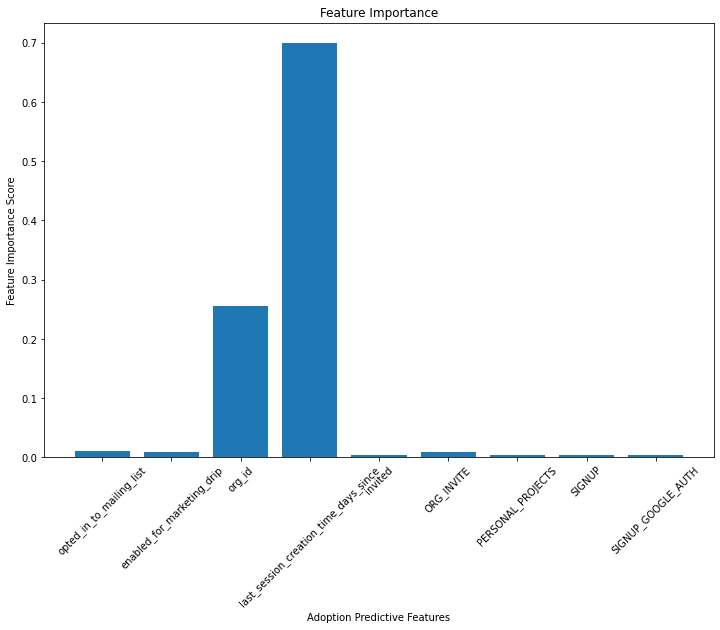

In [16]:
fi = RF.feature_importances_
plt.figure(figsize=(12,8))
plt.bar(range(len(fi)), fi)
xlabels = X.columns
plt.title('Feature Importance')
plt.xlabel('Adoption Predictive Features')
plt.ylabel('Feature Importance Score')
plt.xticks(range(len(xlabels)), xlabels.values, rotation=45)
plt.show()

(array([ 499.,  565.,  575.,  648.,  680.,  703., 3933.,  776.,  940.,
        2681.]),
 array([  0. ,  73.6, 147.2, 220.8, 294.4, 368. , 441.6, 515.2, 588.8,
        662.4, 736. ]),
 <a list of 10 Patch objects>)

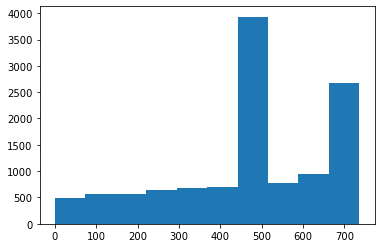

In [20]:
plt.hist(processed_users['last_session_creation_time_days_since'])

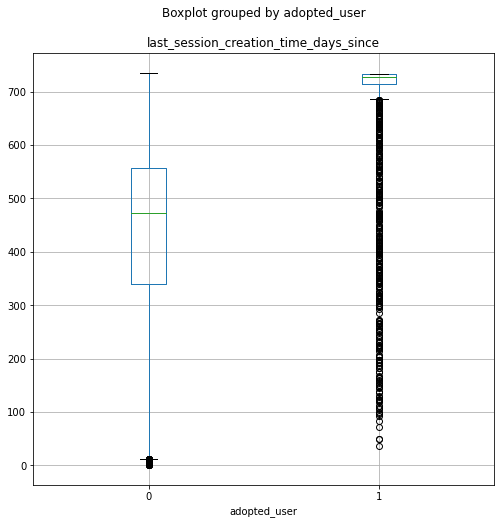

In [35]:
processed_users.boxplot(column =['last_session_creation_time_days_since'], by='adopted_user', figsize=(8,8))